In [309]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# stats
from statsmodels.api import tsa # time series analysis
import statsmodels.api as sm

# JAX
import jax.numpy as jnp
from jax import random, jit
import time

# RELOADING MODULES
import importlib

# UTILS DIRECTORY
import sys
import os

path_ = os.path.abspath(os.path.join('..', '00_utils'))
if path_ not in sys.path:
    sys.path.append(path_)

path_ = os.path.abspath(os.path.join('..', '00_models'))
if path_ not in sys.path:
    sys.path.append(path_)
    
import nn_jax_diffrax

In [310]:
data_path = '../00_data/df_train.csv'
data = pd.read_csv(data_path)

start_date = '2010-01-03'
data = data[data.settlement_date >= start_date]
data.reset_index(drop=True, inplace=True)

end = 400
data_subsample = data[:end]
data_subsample.shape

split = 200
data_subsample.loc[:,'hour'] = pd.to_datetime(data_subsample['settlement_date']).dt.hour

X = data_subsample.drop('nd', axis=1) 
y = data_subsample['nd'] 
X = X[['temperature', 'hour']]

X_train = X[:split]
y_train = y[:split]

X_test = X[split:]
y_test = y[split:]

t = jnp.linspace(0., 1., end)

t_train = t[:split]
t_test = t[split:]

/var/folders/2v/gfm3z1tn5fj8zss_r9hrgnv80000gn/T/ipykernel_75843/2719714624.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_subsample.loc[:,'hour'] = pd.to_datetime(data_subsample['settlement_date']).dt.hour


In [311]:
from sklearn.preprocessing import StandardScaler

scaler_aux = StandardScaler()
X_train_scaled = scaler_aux.fit_transform(X_train)
X_test_scaled = scaler_aux.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled)
X_train_scaled.columns = X_train.columns
X_test_scaled = pd.DataFrame(X_test_scaled)
X_test_scaled.columns = X_test.columns

scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1))

print(t_train.shape)
print(y_train_scaled.shape)
print(X_train_scaled.shape)

(200,)
(200, 1)
(200, 2)


In [312]:
def fetch_delayed_embeddings(file_path, adjusted_start_date, number_of_points):
    """Load data with an offset to accommodate time lags."""
    
    data = pd.read_csv(file_path)
    data['settlement_date'] = pd.to_datetime(data['settlement_date'])
    
    # obtain the subsample
    data_subsample = data[data['settlement_date'] >= adjusted_start_date][:number_of_points]
    
    # extract the target column
    y = data_subsample['nd']
    
    return y

In [313]:
start_date_dt - pd.DateOffset(days=1)

Timestamp('2010-01-02 00:00:00')

In [314]:
start_date_dt = pd.to_datetime(start_date)
offset_date = start_date_dt - pd.DateOffset(days=1)
y_lag1 = fetch_delayed_embeddings(data_path, offset_date, end)

offset_date = start_date_dt - pd.DateOffset(days=7)
y_lag2 = fetch_delayed_embeddings(data_path, offset_date, end)

offset_date = start_date_dt - pd.DateOffset(years=1)
y_lag3 = fetch_delayed_embeddings(data_path, offset_date, end)

# scale
y_lag1_scaled = scaler_y.transform(y_lag1.values.reshape(-1, 1))
y_lag2_scaled = scaler_y.transform(y_lag2.values.reshape(-1, 1))
y_lag3_scaled = scaler_y.transform(y_lag3.values.reshape(-1, 1))

In [316]:
#---------------------------PREPARE THE EXTRA ARGUMENTS--------------------------#
X_train_scaled_jnp = jnp.array(X_train_scaled)
# 'temperature', 'hour'
Xs = jnp.concatenate([y_lag1_scaled[:split], y_lag2_scaled[:split], y_lag3_scaled[:split], X_train_scaled_jnp], axis=1)

ts = jnp.array(t_train)
ys = jnp.array(y_train_scaled)
y0 = jnp.array(y_train_scaled[0])
extra_args = (Xs, ts)

In [317]:
print((ys).dtype)
print((ts).dtype)
print((Xs).dtype)
print((y0).dtype)
print(type(ys))
print(type(ts))
print(type(Xs))
print(type(y0))

float32
float32
float32
float32
<class 'jaxlib.xla_extension.ArrayImpl'>
<class 'jaxlib.xla_extension.ArrayImpl'>
<class 'jaxlib.xla_extension.ArrayImpl'>
<class 'jaxlib.xla_extension.ArrayImpl'>


In [319]:
importlib.reload(nn_jax_diffrax)
NeuralODE_JAX = nn_jax_diffrax.NeuralODE

layer_widths = [6, 64, 64, 1]
learning_rate = 1e-3
rng = random.PRNGKey(42)

node_model = NeuralODE_JAX(layer_widths, time_invariant=True)

state = node_model.create_train_state(rng, learning_rate)

state = node_model.train(state, ts 
                         , ys, y0
                         , num_epochs = 1000
                         , extra_args=extra_args
                         )

To do: @jit/partial decorators missing? what does regularizer do? interpolation can be done a single time before training & function saved
Epoch 100, Loss: 0.7699060440063477
Epoch 200, Loss: 0.7152652740478516
Epoch 300, Loss: 0.6407326459884644
Epoch 400, Loss: 0.6023419499397278
Epoch 500, Loss: 0.5791062116622925
Epoch 600, Loss: 0.5802384614944458
Epoch 700, Loss: 0.571527898311615
Epoch 800, Loss: 0.5698031783103943
Epoch 900, Loss: 0.563824474811554
Epoch 1000, Loss: 0.5618699193000793


In [298]:
data = {
    'y': ys,
    't': ts,
    'X': Xs,
    'extra_args': extra_args,
    'y0': y0
}

import pickle

# Define the filename where the object will be stored
filename = 'cleanup.pkl'

# Open a file for writing the pickled data
with open(filename, 'wb') as file:
    pickle.dump(data, file)


In [343]:
import proprocess_odeint
importlib.reload(proprocess_odeint)
DataPreprocessor = proprocess_odeint.DataPreprocessor

file_path = '../00_data/df_train.csv'
encoding = {'settlement_date': 't', 'temperature': 'var1', 'hour': 'var2', 'nd': 'y'}

data_loader = DataPreprocessor(file_path, start_date = '2010-01-03', number_of_points = 400, tau = 1, m = 1, 
                               feature_encoding = encoding, split = 200, smooth = False, var_weekend = False)
data_subsample = data_loader.load_data()
# df_train, df_test = data_loader.preprocess_data(data_subsample)
d = data_loader.preprocess_data(data_subsample)
df_train, df_test = d[0], d[1]

ys_p = jnp.atleast_2d(jnp.array(df_train['y'])).T
ts_p = jnp.array(df_train['t'])
Xs_p = jnp.array(df_train.drop(columns=['y', 't']))

def ensure_float32(arrays):
    return [x.astype(jnp.float32) if x.dtype != jnp.float32 else x for x in arrays]

ys_p = ensure_float32([ys_p])[0]
ts_p = ensure_float32([ts_p])[0]
Xs_p = ensure_float32([Xs_p])[0]
extra_args_p = (Xs_p, ts_p)
y0_p = jnp.array(ys_p[0])

Start Data: 2010-01-03 00:00:00
days_offset: 1
Offset: 2010-01-02 00:00:00


In [345]:
print((ys_p).dtype)
print((ts_p).dtype)
print((Xs_p).dtype)
print((y0_p).dtype)
print(type(ys_p))
print(type(ts_p))
print(type(Xs_p))
print(type(y0_p))

float32
float32
float32
float32
<class 'jaxlib.xla_extension.ArrayImpl'>
<class 'jaxlib.xla_extension.ArrayImpl'>
<class 'jaxlib.xla_extension.ArrayImpl'>
<class 'jaxlib.xla_extension.ArrayImpl'>


In [347]:
importlib.reload(nn_jax_diffrax)
NeuralODE_JAX = nn_jax_diffrax.NeuralODE

layer_widths = [6, 64, 64, 1]
learning_rate = 1e-3
rng = random.PRNGKey(42)

node_model = NeuralODE_JAX(layer_widths, time_invariant=True)

state = node_model.create_train_state(rng, learning_rate)

state = node_model.train(state, ts_p 
                         , ys_p, y0_p
                         , num_epochs = 1000
                         , extra_args=extra_args_p
                         )

To do: @jit/partial decorators missing? what does regularizer do? interpolation can be done a single time before training & function saved
Epoch 100, Loss: 0.7699060440063477
Epoch 200, Loss: 0.7152652740478516
Epoch 300, Loss: 0.6407326459884644
Epoch 400, Loss: 0.6023419499397278
Epoch 500, Loss: 0.5791062116622925
Epoch 600, Loss: 0.5802384614944458
Epoch 700, Loss: 0.571527898311615
Epoch 800, Loss: 0.5698031783103943
Epoch 900, Loss: 0.563824474811554
Epoch 1000, Loss: 0.5618699193000793


In [274]:
import neural_net_jax_diffrax
importlib.reload(neural_net_jax_diffrax)
NeuralODE_JAX = neural_net_jax_diffrax.NeuralODE

# reload
node_model = NeuralODE_JAX(layer_widths, time_invariant=True)

#  def neural_ode(self, params, y0, t, state, extra_args=None): 
y_train_pred = node_model.neural_ode(state.params, y0, ts, state, extra_args)

ValueError: x and y can be no greater than 2D, but have shapes (200,) and (200, 1, 1)

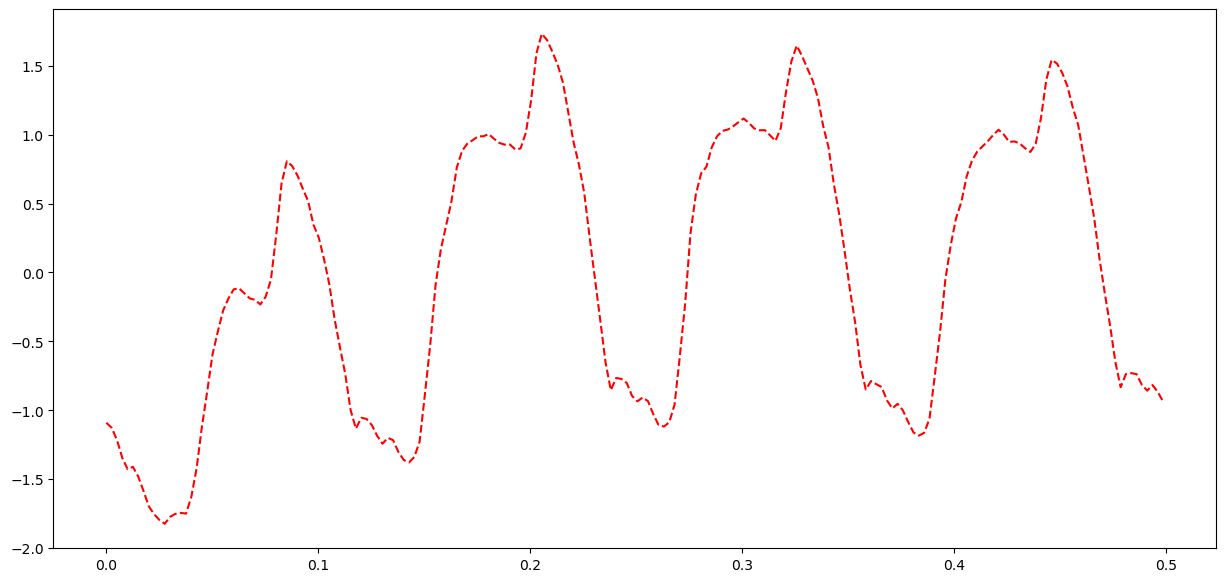

In [275]:
#---------------------------PLOTTING RESULTS--------------------------#
plt.figure(figsize=(15, 7))

plt.plot(ts, ys, 'r--', label='True Data u(t)')  
plt.plot(ts, y_train_pred, 'b', label='Predicted Data u(t)') 

plt.xlabel('Time')
plt.ylabel('u(t)')
plt.legend(loc ="lower right")
plt.grid(True)
plt.show()

#### `Sanity Check`
## Pytorch Model 

In [158]:
p_ = os.path.abspath(os.path.join('..', '00_models'))
if p_ not in sys.path:
    sys.path.append(p_)

import nn_pytorch
import torch

In [173]:
ys_torch = torch.tensor(np.array(ys), dtype=torch.float32)
ts_torch = torch.tensor(np.array(ts), dtype=torch.float32)
Xs = X_train_scaled_embed
y0_torch = torch.tensor(np.array(ys[0]), dtype=torch.float32)

print(ys_torch.shape)
print(ts_torch.shape)
print(Xs.shape)
print(y0_torch.shape)
print(y0_torch)

torch.Size([200, 1])
torch.Size([200])
(200, 4)
torch.Size([1])
tensor([-1.0902])


In [183]:
importlib.reload(nn_pytorch)
NeuralODE = nn_pytorch.NeuralODE

layer_widths = [5, 30, 30, 1]
learning_rate = 1e-1

y_pred_results = {}

ode_model = NeuralODE(layer_widths, learning_rate, time_invariant = True)

for k in [int(len(ts)*0.1), len(ts)]:
    ode_model.train_model(ts_torch[:k], ys_torch[:k], y0_torch, num_epochs = 300, extra_inputs = Xs[:k])

Epoch 0, Loss: 0.24062733352184296
Epoch 100, Loss: 0.07791294902563095
Epoch 200, Loss: 0.03950398415327072
Epoch 0, Loss: 1.6918158531188965
Epoch 100, Loss: 0.1734839230775833
Epoch 200, Loss: 0.06187210604548454


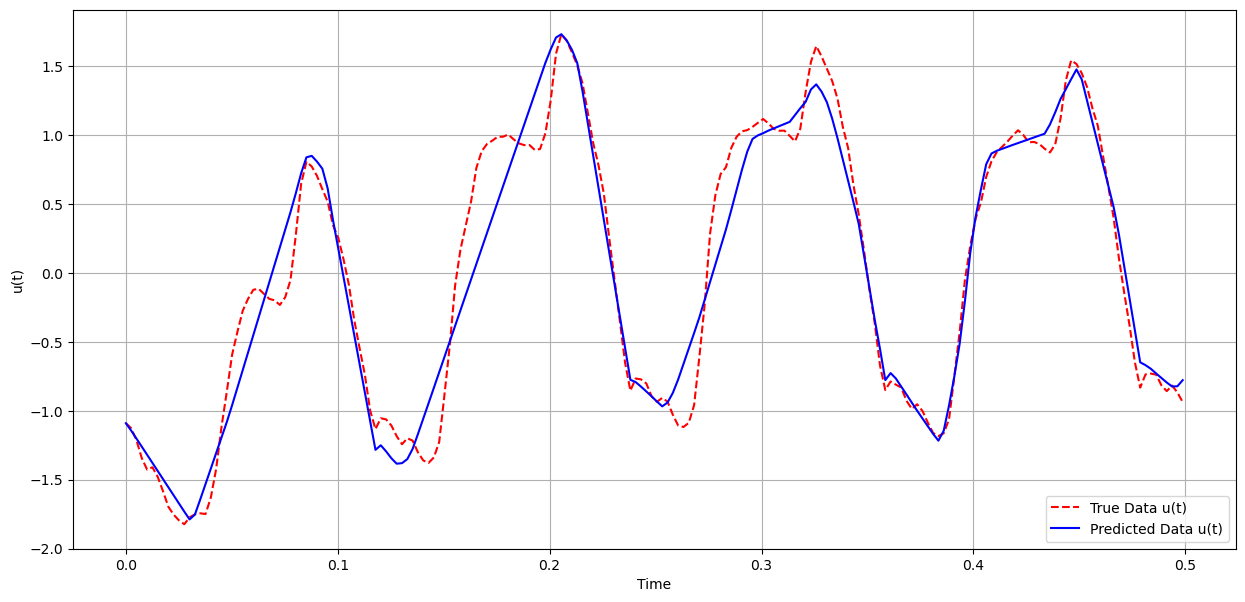

In [184]:
y_train_pred = ode_model.predict(ts_torch, y0_torch)

plt.figure(figsize=(15, 7))

plt.plot(ts, ys, 'r--', label='True Data u(t)')  
plt.plot(ts, y_train_pred, 'b', label='Predicted Data u(t)') 

plt.xlabel('Time')
plt.ylabel('u(t)')
plt.legend(loc ="lower right")
plt.grid(True)
plt.show()